In [ ]:
import numpy as np
import os
import matplotlib.pyplot as plt


import torch
from torch.utils.data import DataLoader


# Performance measure
from ignite.metrics import SSIM
from torchmetrics import MeanSquaredError
from torchmetrics import MeanAbsoluteError
from torchmetrics import SignalNoiseRatio
from torchmetrics.image import PeakSignalNoiseRatio

from models import UNet4D 
from train_utils import predictions, CreateDataset

In [2]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f'Device: {device}')

torch.set_default_dtype(torch.float32) 

Device: cuda


In [3]:
def set_seed(seed=42):
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)

set_seed(42)

### Loading test data

The test data was saved into a spesific folder during preprocessing.

In [4]:
X_test_path = '../../preprocessed_4d/ls_test'

y_test_path = '../../preprocessed_4d/epi_test'

X_test_files = [f for f in os.listdir(X_test_path) if f.endswith('.pt')]
X_test = [torch.load(os.path.join(X_test_path, f)) for f in X_test_files]

y_test_files = [f for f in os.listdir(y_test_path) if f.endswith('.pt')]
y_test = [torch.load(os.path.join(y_test_path, f)) for f in y_test_files]


C:\Users\Caroline\AppData\Local\Temp\ipykernel_3840\2228507834.py:6: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  X_test = [torch.load(os.path.join(X_test_path, f)) for f i

In [5]:
test_dataset = CreateDataset(X_test, y_test)

### Calculating performance measurements

Calculating MAE, MSE, SSIM and 

In [ ]:
def calc_MAE(preds, label):
    mae = MeanAbsoluteError()
    return mae(preds, label)

def calc_MSE(preds, label):
    mse = MeanSquaredError()
    return mse(preds, label)

def calc_SSIM_eval(preds, true):
    preds = preds.squeeze(0,1)
    true = true.squeeze(0,1)
    metric = SSIM(data_range=1)
    metric.update((preds, true))
    ssim_value = metric.compute()
    return ssim_value

def calc_PSNR(preds, true):
    psnr = PeakSignalNoiseRatio()
    return psnr(preds, true)

### Loading the best model

In order to determine the generalizability, the best performing model is loaded and evaluated on the test data, which is previosly unseen for the model.

In [8]:
best_MSE_model = UNet4D()

checkpoint_MSE = torch.load('../../4D_models/4D_model_weights/MSE_lr5e-5/weights_model_lr5e-05_epoch30.pth', map_location=device)
best_MSE_model.load_state_dict(checkpoint_MSE['model_state_dict'])

best_MSE_model.eval()

best_MSE_model.to(device=device)

batch_size = 1
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=True, generator=torch.Generator().manual_seed(42))
preds, true = predictions(best_MSE_model, test_loader)

C:\Users\Caroline\AppData\Local\Temp\ipykernel_3840\347571607.py:3: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint_MSE = torch.load('../../4D_models/4D_model_weigh

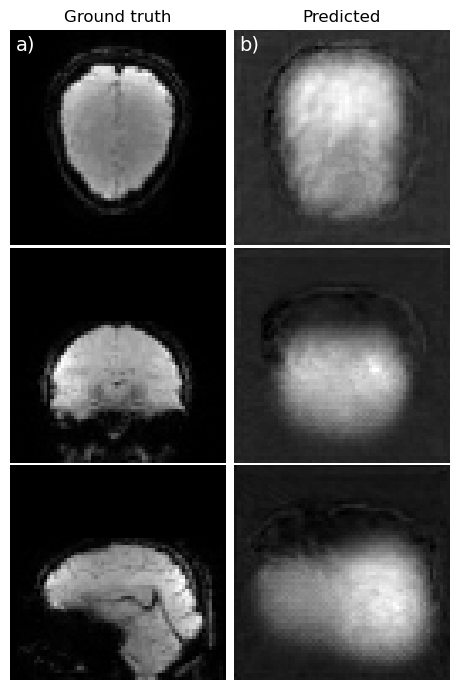

In [13]:
preds_cpu = preds[0].cpu()
true_cpu = true[0].cpu()
preds0= preds_cpu.squeeze(0,1)
true0= true_cpu.squeeze(0,1)

fig, ax = plt.subplots(nrows=3, ncols=2, figsize =(5,7))

i = 32

ax[0,0].imshow(np.rot90(true0[12,:,:,i]), cmap='gray')
ax[0,0].axis('off')
ax[0,0].set_title('Ground truth')
ax[0,0].text(7,1,'a)', ha='right', va='top', fontsize=14, color='white')

ax[0,1].imshow(np.rot90(preds0[12,:,:,i]), cmap='gray')
ax[0,1].axis('off')
ax[0,1].set_title('Predicted')
ax[0,1].text(7,1,'b)', ha='right', va='top', fontsize=14, color='white')

ax[1,0].imshow(np.rot90(true0[12,:,i,:]), cmap='gray')
ax[1,0].axis('off')
ax[1,1].imshow(np.rot90(preds0[12,:,i,:]), cmap='gray')
ax[1,1].axis('off')

ax[2,0].imshow(np.rot90(true0[12,i,:,:]), cmap='gray')
ax[2,0].axis('off')
ax[2,1].imshow(np.rot90(preds0[12,i,:,:]), cmap='gray')
ax[2,1].axis('off')
plt.tight_layout()

plt.subplots_adjust( hspace=0.01, wspace=-0.09)
plt.show()

In [16]:
print('Loss function: MSE')
print(f'MAE: {calc_MAE(preds_cpu, true_cpu)}')
print(f'MSE: {calc_MSE(preds_cpu, true_cpu)}')
print(f'SSIM: {calc_SSIM_eval(preds_cpu, true_cpu)}')
print(f'PSNR: {calc_PSNR(preds_cpu, true_cpu)}')

Loss function: MSE
MAE: 0.03698127344250679
MSE: 0.00534435547888279
SSIM: 0.5703147090413606
PSNR: 22.721044540405273
